In [1]:
import sys

# adapt paths
sys.path.append("/home/cctrotte/krauthammer/stcs_code/pysurvival_mine/")

In [4]:
#### 1 - Importing packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pysurvival_mine.models.simulations import SimulationModel
from pysurvival_mine.models.survival_forest import ConditionalSurvivalForestModel
from pysurvival_mine.utils.metrics import concordance_index
from pysurvival_mine.utils.display import integrated_brier_score
%pylab inline

#### 2 - Generating the dataset from a Exponential parametric model
# Initializing the simulation model
sim = SimulationModel( survival_distribution = 'exponential',
                       risk_type = 'linear',
                       censored_parameter = 1,
                       alpha = 3)

# Generating N random samples 
N = 1000
dataset = sim.generate_data(num_samples = N, num_features=4)

# Showing a few data-points 
dataset.head(2)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Number of data-points: 1000 - Number of events: 515.0


,x_1,x_2,x_3,x_4,time,event
0,1.807639,19.583905,0.138151,0.010914,0.023806,1.0
1,1.252855,8.599940,0.046659,0.022122,0.000000,0.0


C-index: 0.79


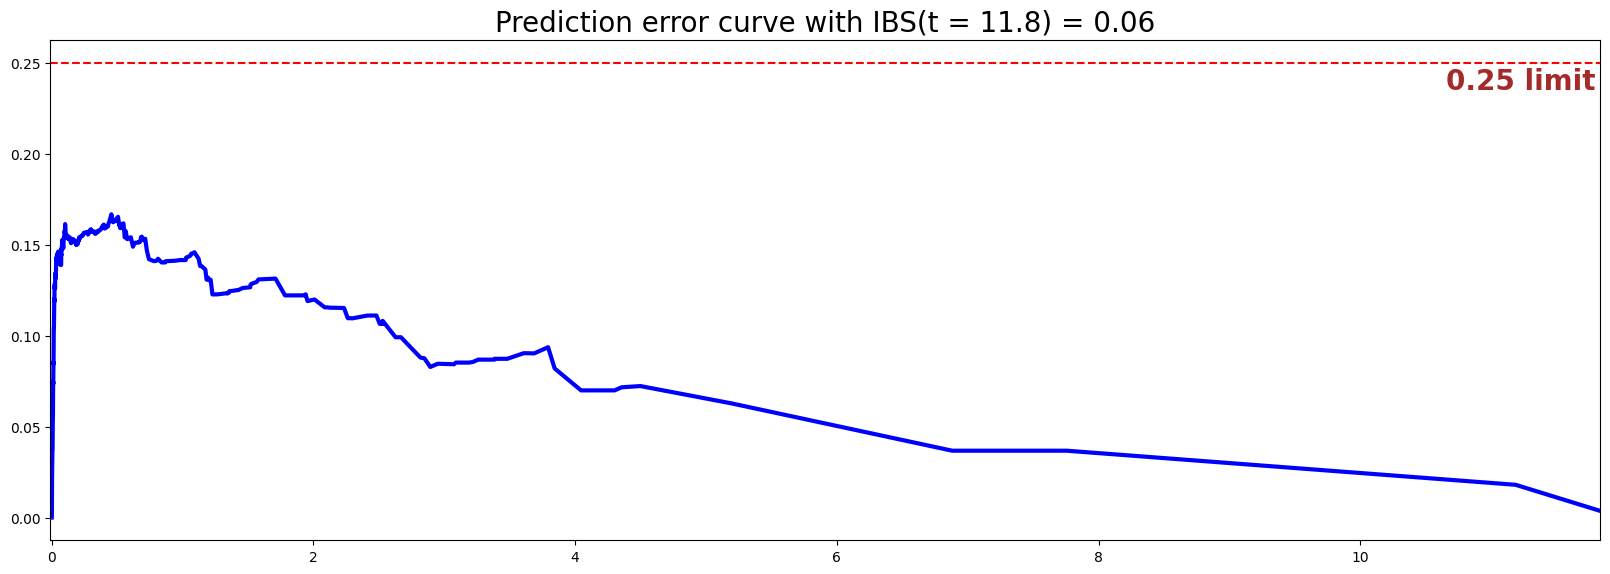

IBS: 0.06


In [5]:
#### 3 - Creating the modeling dataset
# Defining the features
features = sim.features

# Building training and testing sets #
index_train, index_test = train_test_split( range(N), test_size = 0.2)
data_train = dataset.loc[index_train].reset_index( drop = True )
data_test  = dataset.loc[index_test].reset_index( drop = True )

# Creating the X, T and E input
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train['time'].values, data_test['time'].values
E_train, E_test = data_train['event'].values, data_test['event'].values
X_valid, T_valid, E_valid = X_test, T_test, E_test

#### 4 - Creating an instance of the NonLinear CoxPH model and fitting 
# the data.

# Defining the MLP structure. Here we will build a 1-hidden layer 
# with 150 units and `BentIdentity` as its activation function


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)


#### 4 - Creating an instance of the Conditional model and fitting the data.
# Building the model
csf = ConditionalSurvivalForestModel(num_trees=200)
csf.fit(X_train, T_train, E_train,
        max_features="sqrt", max_depth=5, min_node_size=20,
        alpha = 0.05, minprop=0.1)


#### 5 - Cross Validation / Model Performances
c_index = concordance_index(csf, X_test, T_test, E_test) #0.81
print('C-index: {:.2f}'.format(c_index))

ibs = integrated_brier_score(csf, X_test, T_test, E_test, t_max=30,
            figure_size=(20, 6.5) )
print('IBS: {:.2f}'.format(ibs))